# Molecular Dynamics of Antibody-Antigen Complexes

In [ ]:
# conda install -c conda-forge pdbfixer openmm matplotlib

In [1]:
## Load Libraries
from openmm.app import *
from openmm import *
from openmm.unit import *
from openmm.app import PDBFile
from pdbfixer import PDBFixer

from sys import stdout
import os

In [2]:
## Define Input PDB Structure
input_pbd_file = '../../docking/outputs/best_pdbs/TUPPD1-001_61w.pdb'

output_pdb_file = input_pbd_file.replace('../../docking/outputs/best_pdbs/', './clean_pdbs/').replace('.pdb', '_clean.pdb')

print('Cleaning up PDB file...')
print(f'\tInput PDB File: {input_pbd_file}')

## Make folders for output file
output_folder = os.path.dirname(output_pdb_file)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Cleaning up PDB file...
	Input PDB File: ../../docking/outputs/best_pdbs/TUPPD1-001_61w.pdb


In [3]:
## Fix PDB file to repair missing hydrogens and other issues
print('Preparing PDB file...')

fixer = PDBFixer(filename=input_pbd_file)
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
# fixer.addMissingHydrogens(7.0)
fixer.addMissingHydrogens(7.4)
# fixer.addSolvent(fixer.topology.getUnitCellDimensions())
PDBFile.writeFile(fixer.topology, fixer.positions, open(output_pdb_file, 'w'))

print(f'\tOutput PDB File: {output_pdb_file}')

Preparing PDB file...


	Output PDB File: ./clean_pdbs/TUPPD1-001_61w_clean.pdb


In [23]:
## Make Forcefield and Modeller
print('Creating Force Field...')
pdb = PDBFile(output_pdb_file)
# forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
forcefield = ForceField('charmm36.xml', 'charmm36/water.xml')

# modeller = Modeller(pdb.topology, pdb.positions)
modeller = Modeller(fixer.topology, fixer.positions)
modeller.deleteWater()

residues = modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, padding=1.0*nanometer)

# PDBFile.writeFile(modeller.topology, modeller.positions, open(output_pdb_file, 'w'))

Creating Force Field...


In [24]:
print('Creating Simulation System...')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

Creating Simulation System...


In [25]:
## Minimize Energy
print("Minimizing energy...")
simulation.minimizeEnergy(maxIterations = 250)
# simulation.minimizeEnergy()
## In theory, we're already at the lowest (or low-ish) energy from HADDOCK?

Minimizing energy...


In [17]:
## Equilibrate
simulation.reporters.append(PDBReporter(output_pdb_file, 1000))
simulation.reporters.append(StateDataReporter(stdout,
                                              1000,
                                              step=True,
                                              potentialEnergy=True,
                                              temperature=True,
                                              volume=True))

output_pdb_md_log_file = output_pdb_file.replace('.pdb', '_log.txt')

simulation.reporters.append(StateDataReporter(output_pdb_md_log_file,
                                              100,
                                              step=True,
                                              potentialEnergy=True,
                                              temperature=True,
                                              volume=True))

In [26]:
## Run NVT
print("Running NVT...")
n_steps = 10000
simulation.step(n_steps)

Running NVT...


In [27]:
## Run NPT
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)

print("Running NPT...")
simulation.step(10000)

Running NPT...


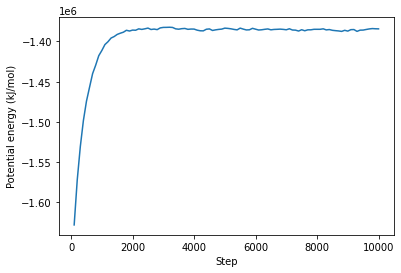

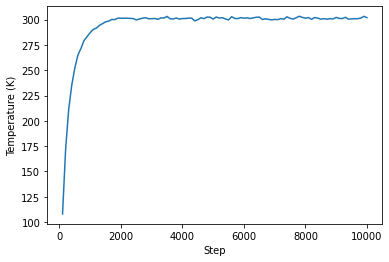

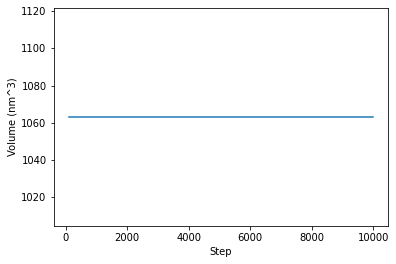

In [28]:

## Plot Results
import numpy as np
import matplotlib.pyplot as plt

## Load Data
data = np.loadtxt(output_pdb_md_log_file, delimiter=',')

step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

## Potential Energy
plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.savefig(output_pdb_file.replace('.pdb', '_potential_energy.png'))
plt.show()


## Temperature
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.savefig(output_pdb_file.replace('.pdb', '_temperature.png'))
plt.show()

## Volume
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.savefig(output_pdb_file.replace('.pdb', '_volume.png'))
plt.show()

In [ ]:
## Output Full PDB (post-simulation)

positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(f'{output_pdb_file}_FULL.pdb', 'w'))